In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import linear_model
from sklearn.metrics import r2_score
from sklearn.model_selection import train_test_split

In [2]:
data = pd.read_csv('Hitters.csv')
data = pd.get_dummies(data, columns=['League','Division','NewLeague'])
target = 'Salary'
data = data[data['Salary'].notnull()]

In [3]:
def calibracion(predicciones, y, bins):
    df_calibracion = pd.DataFrame({
        'predicciones': predicciones,
        'y': y
    })
    df_calibracion['bins'] = pd.qcut(df_calibracion['predicciones'], q = bins, labels=False) + 1
    grouped = df_calibracion.groupby('bins').mean()
    plt.plot(grouped.predicciones, grouped.y, marker='o', label = 'Modelo', color = 'skyblue')
    plt.plot(grouped.predicciones, grouped.predicciones, marker='o', label = 'Real', color = 'indianred')
    plt.xlabel('Predicción')
    plt.ylabel('Real')
    plt.legend()
    plt.grid()

## Regresión lineal Examen

In [4]:
# De rendimiento actual
data['Hits_per_AtBat'] = data['Hits'] / data['AtBat']
data['HmRun_per_Hits'] = data['HmRun'] / data['Hits']
data['RBIs_per_Hits'] = data['RBI'] / data['Hits']
data['Runs_per_Hits'] = data['Runs'] / data['Hits']

# De rendimiento histórico
data['CHits_per_CAtBat'] = data['CHits'] / data['CAtBat']
data['CHmRun_per_CHits'] = data['CHmRun'] / data['CHits']
data['CRuns_per_CHits'] = data['CRuns'] / data['CHits']
data['Years_AvgHits'] = data['CHits'] / data['Years']

# Transformaciones
data['log_CRuns'] = np.log(data['CRuns']+1)
data['sqrt_CHits'] = np.sqrt(data['CHits']+1)

R2: 0.7134


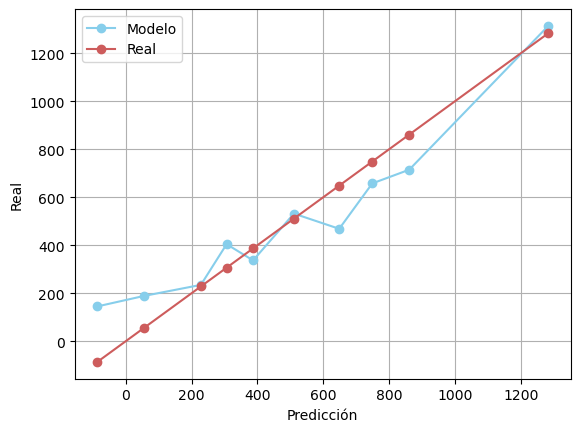

In [5]:
X = data.copy()
X = X.drop(columns=[target])
y = data[target]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = linear_model.LinearRegression()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(f'R2: {r2_score(y_test, y_pred):.4f}')
calibracion(y_pred, y_test, 10)

## Modelos Boosting

In [6]:
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor, early_stopping, log_evaluation

### XGBoost

In [7]:
model = XGBRegressor(
    n_estimators=100,
    max_depth=8,
    learning_rate=0.1,
    reg_lambda=0.1,
    subsample=0.5,
    colsample_bytree=0.8,
    tree_method='hist',
    early_stopping_rounds=20,
)

model.fit(X_train, y_train,
          eval_set=[(X_train, y_train), (X_test, y_test)],
          verbose=100)

[0]	validation_0-rmse:420.41652	validation_1-rmse:404.13365
[55]	validation_0-rmse:36.99810	validation_1-rmse:285.12729


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=20,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.1, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=8,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

R2: 0.5644


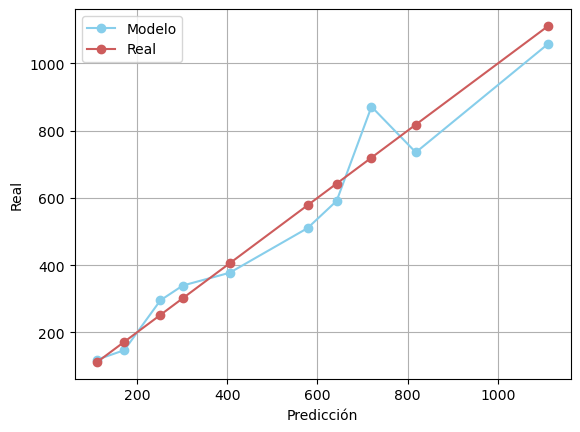

In [8]:
predicciones = model.predict(X_test)
r2 = r2_score(y_test, predicciones)
print(f'R2: {r2:.4f}')
calibracion(predicciones, y_test, 10)

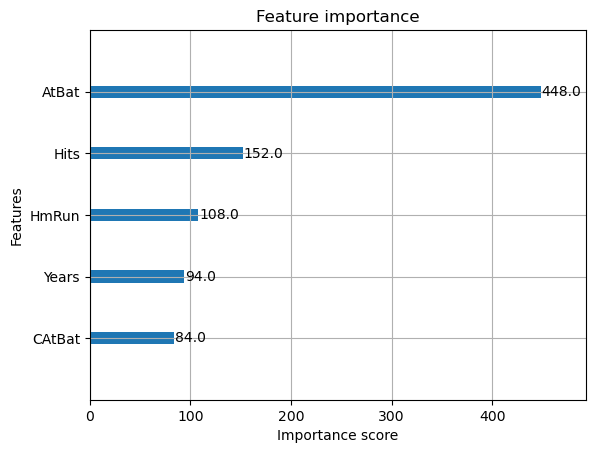

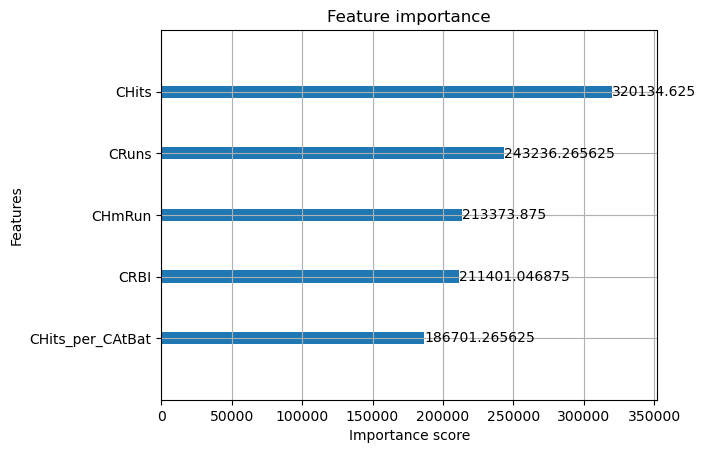

In [9]:
from xgboost import plot_importance
plot_importance(model, max_num_features=5, importance_type='weight');
plot_importance(model, max_num_features=5, importance_type='gain');

### Lightgbm

In [10]:
model = LGBMRegressor(
    n_estimators=1000,
    num_leaves=10,
    learning_rate=0.1,
    max_depth=8,
    lambda_l2=0.1,
    subsample=0.8,
    feature_fraction=0.8,
    verbosity=-1
)

model.fit(X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)],
          eval_metric='rmse',
          callbacks=[early_stopping(20),
                     log_evaluation(100)])

Training until validation scores don't improve for 20 rounds
[100]	training's rmse: 100.341	training's l2: 10068.4	valid_1's rmse: 348.182	valid_1's l2: 121231
Early stopping, best iteration is:
[90]	training's rmse: 110.151	training's l2: 12133.3	valid_1's rmse: 347.237	valid_1's l2: 120573


LGBMRegressor(feature_fraction=0.8, lambda_l2=0.1, max_depth=8,
              n_estimators=1000, num_leaves=10, subsample=0.8, verbosity=-1)

R2: 0.3334


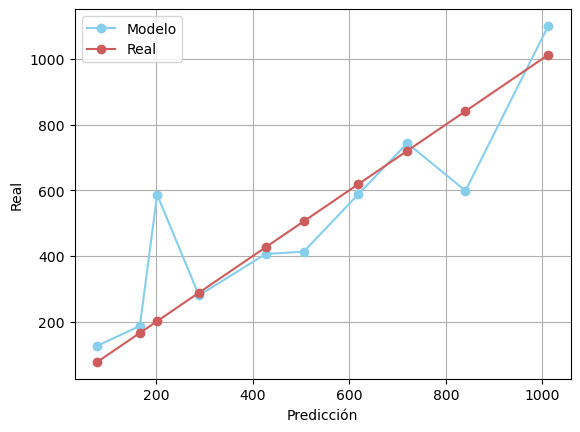

In [11]:
predicciones = model.predict(X_test)
r2 = r2_score(y_test, predicciones)
print(f'R2: {r2:.4f}')
calibracion(predicciones, y_test, 10)

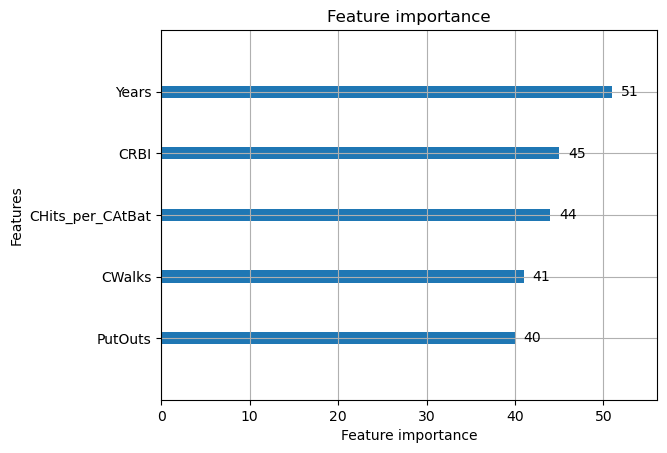

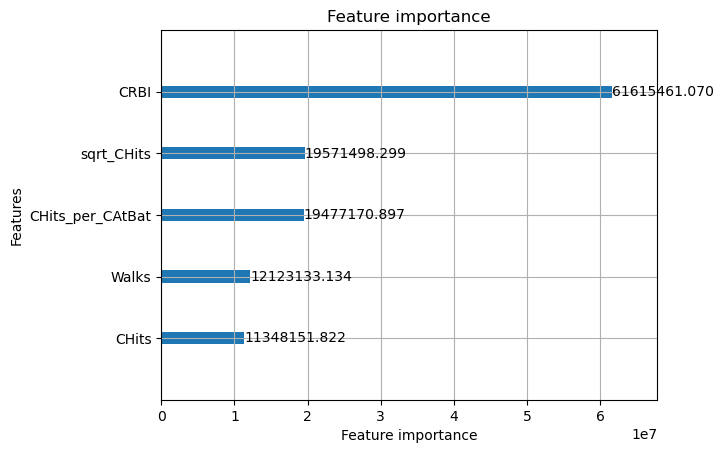

In [12]:
from lightgbm import plot_importance
plot_importance(model, max_num_features=5, importance_type='split');
plot_importance(model, max_num_features=5, importance_type='gain');